In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sla
import scipy.sparse.linalg as spla
import scipy.io as sio
import meshio
import dolfin as dl
from time import time

import localpsfcpp as lpsf

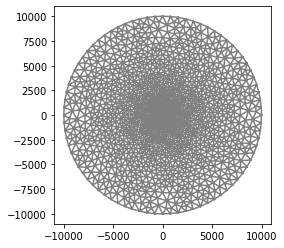

In [2]:
vertices = np.loadtxt('../data/mesh_vertices.txt')
cells = np.loadtxt('../data/mesh_cells.txt', dtype=int)
dof_coords = np.loadtxt('../data/dof_coords.txt')
vertex_in_dof = np.loadtxt('../data/vertex_in_dof.txt', dtype=int)
dof_in_vertex = np.loadtxt('../data/dof_in_vertex.txt', dtype=int)

mesh_meshio = meshio.Mesh(vertices, [("triangle", cells)])
mesh_meshio.write("../tmp/mesh.xml")
mesh = dl.Mesh("../tmp/mesh.xml")
dl.plot(mesh)

In [3]:
Hdgn = np.loadtxt('../data/Hdgn_array.txt')
sqrtR = sio.loadmat('../data/sqrtR_matrix.mat')['sqrtR']
M = sio.loadmat('../data/mass_matrix.mat')['M']
# mass_lumps = np.loadtxt('mass_matrix_diagonal.txt')
mass_lumps = M * np.ones(M.shape[1])

Ker = Hdgn / (mass_lumps.reshape(1,-1) * mass_lumps.reshape(-1,1))

apply_Hdgn = lambda x: np.dot(Hdgn, x)
apply_HdgnT = lambda x: np.dot(Hdgn, x)
apply_M = lambda x: M * x
solve_M = spla.factorized(M)
apply_ML = lambda x: x * mass_lumps
solve_ML = lambda x: x / mass_lumps

In [4]:
R = sqrtR.toarray().T @ np.linalg.solve(M.toarray(), sqrtR.toarray())

In [5]:
V = dl.FunctionSpace(mesh, 'CG', 1)

err_dof_coords = np.linalg.norm(dof_coords - V.tabulate_dof_coordinates()) / np.linalg.norm(V.tabulate_dof_coordinates())
print('err_dof_coords=', err_dof_coords)

err_dof_coords= 0.0


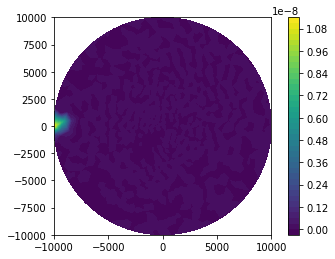

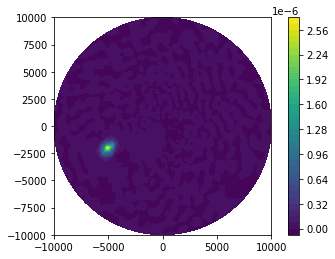

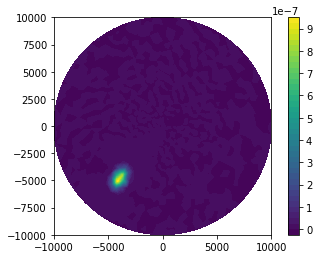

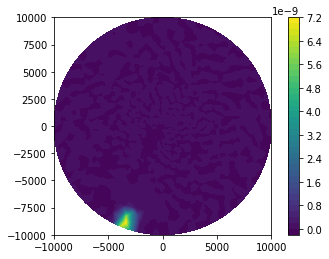

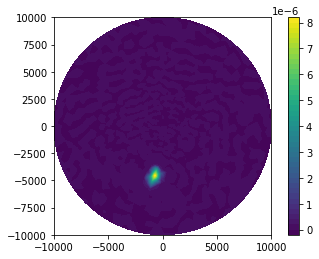

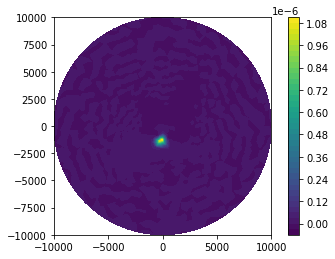

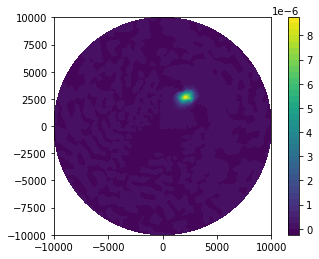

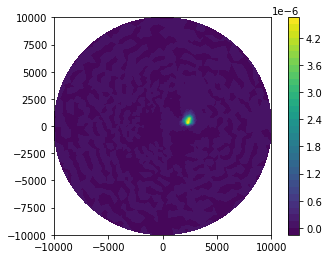

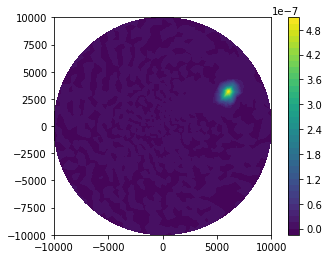

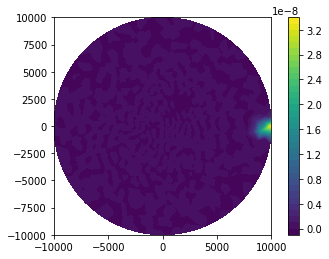

In [6]:
kk = list(np.linspace(0,V.dim()-1,10,dtype=int))
for k in kk:
    ek = np.zeros(V.dim())
    ek[k] = 1.0
    psi_k = dl.Function(V)
    psi_k.vector()[:] = solve_ML(apply_Hdgn(solve_ML(ek)))

    plt.figure()
    cm = dl.plot(psi_k)
    plt.colorbar(cm)

In [7]:
err_reorder = np.linalg.norm(dof_coords - vertices[dof_in_vertex,:]) / np.linalg.norm(dof_coords)
print('err_reorder=', err_reorder)

vertices_dof_order = np.array(vertices[dof_in_vertex,:].T, order='C')
# cells_dof_order    = np.array(cells[dof_in_vertex,:].T,    order='C') # BAD
cells_dof_order    = np.array(vertex_in_dof[cells].T,    order='C') # GOOD

err_reorder= 0.0


In [8]:
from matplotlib.patches import Ellipse

def plot_ellipse(mu, Sigma, n_std_tau, ax=None, **kwargs):
    # Usage:
    #   https://github.com/NickAlger/nalger_helper_functions/tree/master/jupyter_notebooks/plot_ellipse.ipynb
    if ax is None:
        ax = plt.gca()

    ee, V = np.linalg.eigh(Sigma)
    e_big = ee[1]
    e_small = ee[0]
    v_big = V[:, 1]
    theta = np.arctan(v_big[1] / v_big[0]) * 180. / np.pi

    long_length = n_std_tau * 2. * np.sqrt(e_big)
    short_length = n_std_tau * 2. * np.sqrt(e_small)

    if not ('facecolor' in kwargs):
        kwargs['facecolor'] = 'none'

    if not ('edgecolor' in kwargs):
        kwargs['edgecolor'] = 'k'

    ellipse = Ellipse(mu, width=long_length, height=short_length, angle=theta, **kwargs)
    ax.add_artist(ellipse)

computing V
computing mu
ii = 0
ii = 1
computing Sigma
ii = 0, jj = 0
ii = 1, jj = 0
ii = 1, jj = 1


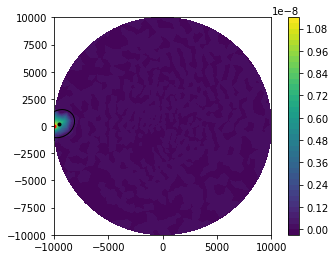

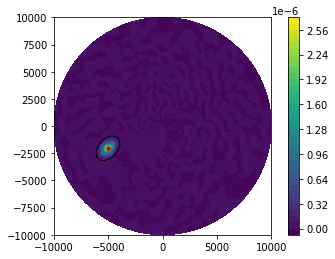

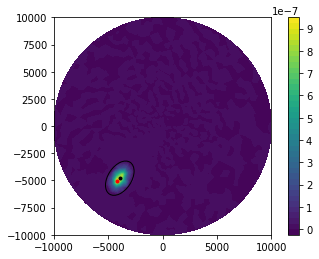

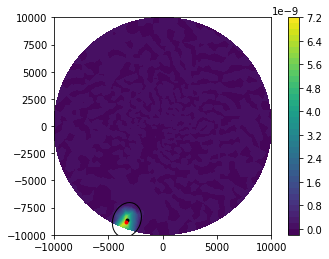

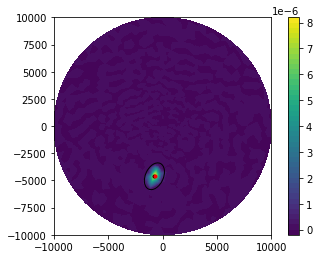

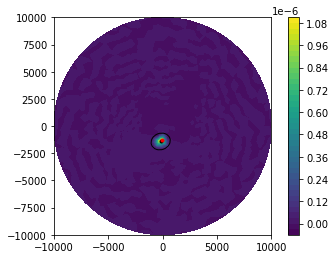

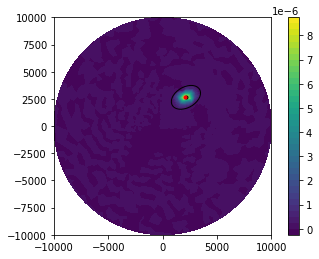

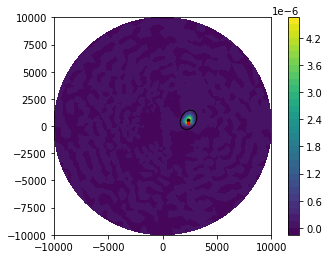

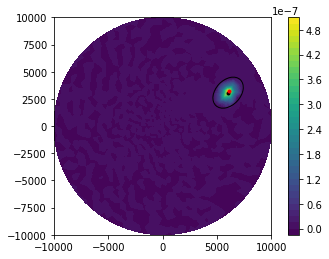

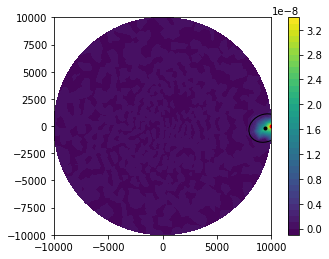

In [9]:
vol, mu, Sigma = lpsf.compute_impulse_response_moments(apply_HdgnT, solve_ML, vertices_dof_order)
# vol, mu, Sigma = lpsf.compute_impulse_response_moments(apply_HdgnT, solve_M, vertices_dof_order)

tau = 3.0

kk = list(np.linspace(0,V.dim()-1,10,dtype=int))
for k in kk:
    ek = np.zeros(V.dim())
    ek[k] = 1.0
    psi_k = dl.Function(V)
    psi_k.vector()[:] = solve_ML(apply_Hdgn(solve_ML(ek)))

    plt.figure()
    cm = dl.plot(psi_k)
    plt.colorbar(cm)
    plt.plot(mu[k][0], mu[k][1], '.k')
    plot_ellipse(mu[k], Sigma[k], tau, edgecolor='k')
    plt.plot(vertices_dof_order[0,k], vertices_dof_order[1,k], '.r')

In [10]:
num_neighbors = 10
min_vol_rtol = 1e-5
num_initial_batches = 5

lpsf_kernel = lpsf.create_LPSFKernel(apply_Hdgn, apply_HdgnT, apply_ML, apply_ML, solve_ML, solve_ML, 
                                    vertices_dof_order, vertices_dof_order, cells_dof_order, 
                                    tau, num_neighbors, min_vol_rtol, num_initial_batches)

computing V
computing mu
ii = 0
ii = 1
computing Sigma
ii = 0, jj = 0
ii = 1, jj = 0
ii = 1, jj = 1
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch


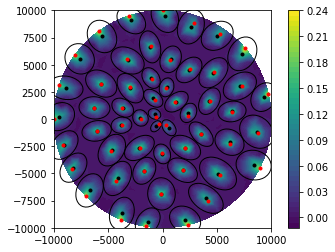

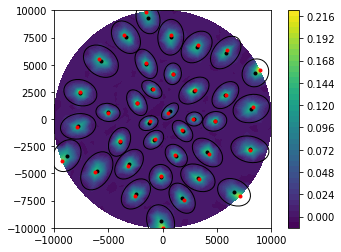

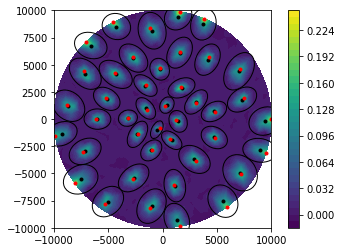

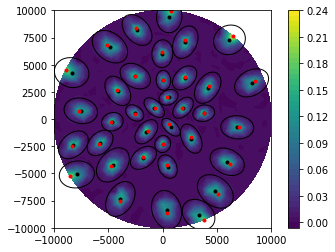

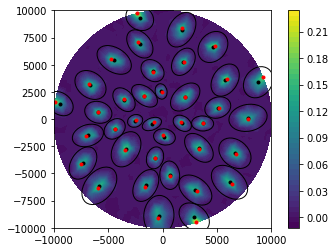

In [11]:
for b in range(len(lpsf_kernel.eta_batches)):
    eta_b = dl.Function(V)
    eta_b.vector()[:] = lpsf_kernel.eta_batches[b]

    plt.figure()
    cm = dl.plot(eta_b)
    plt.colorbar(cm)
    for ind in lpsf_kernel.dirac_ind_batches[b]:
        plt.plot(mu[ind][0], mu[ind][1], '.k')
        plot_ellipse(mu[ind], Sigma[ind], tau, edgecolor='k')
        plt.plot(vertices_dof_order[0,ind], vertices_dof_order[1,ind], '.r')

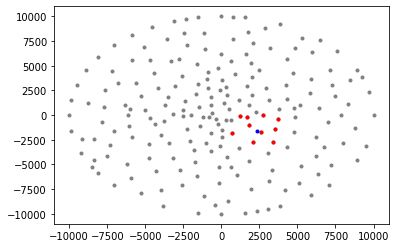

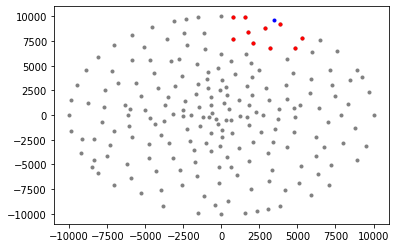

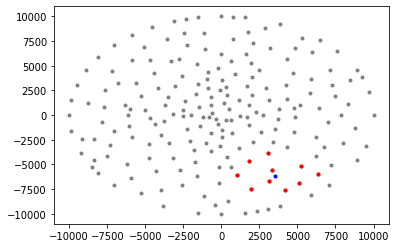

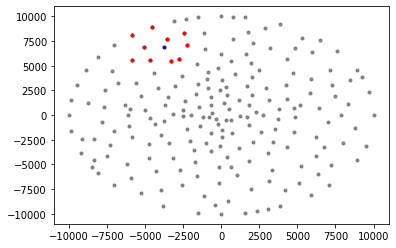

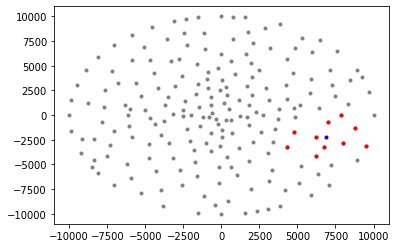

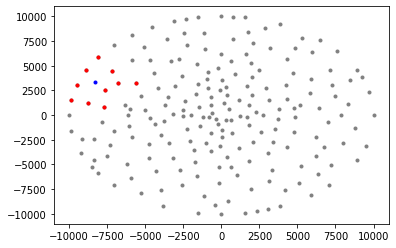

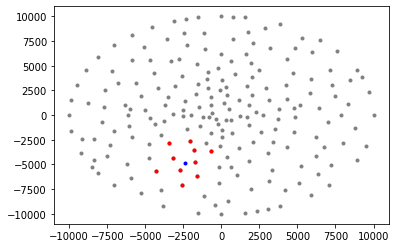

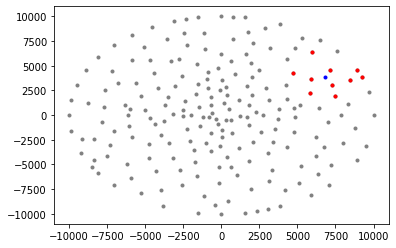

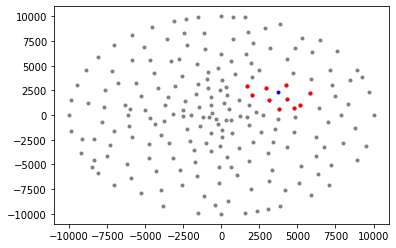

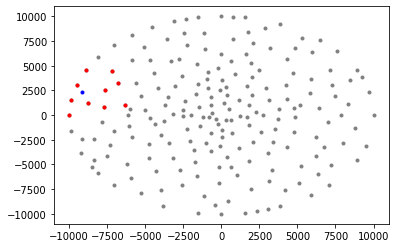

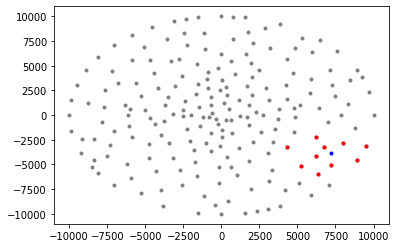

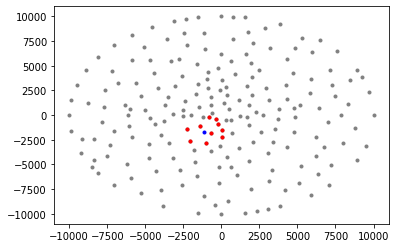

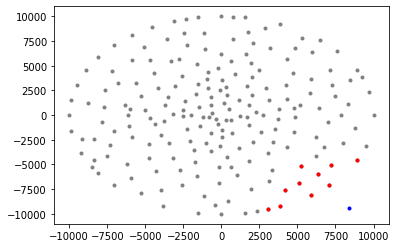

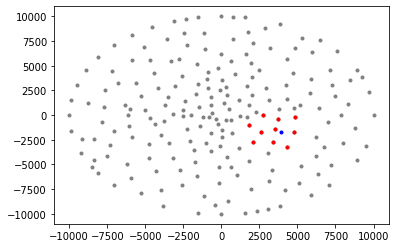

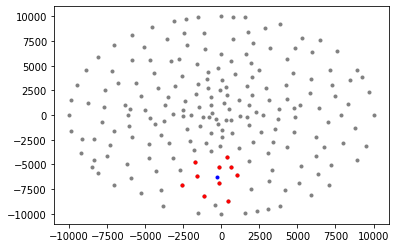

In [12]:
query_points = [np.array(1e4*(2*np.random.rand(2,1)-1), order='C') for _ in range(15)]

for q in query_points:
    nearest_inds = lpsf_kernel.dirac_kdtree.query(q, 10)[0].reshape(-1)

    plt.figure()
    for ind in lpsf_kernel.dirac_inds:
        plt.plot(lpsf_kernel.source_vertices[ind][0], lpsf_kernel.source_vertices[ind][1], '.', c='gray')

    for ind in nearest_inds:
            plt.plot(lpsf_kernel.dirac_points[ind][0], lpsf_kernel.dirac_points[ind][1], '.r')

    plt.plot(q[0], q[1], '.b')

In [13]:
R_ker = ( 1.0 / mass_lumps.reshape((-1,1)) ) * (R / mass_lumps.reshape((1,-1)))

num_entries = 15
row_inds = list(np.random.randint(0, V.dim(), num_entries))
# col_inds = list(np.random.randint(0, V.dim(), num_entries))
col_inds = row_inds
use_symmetry = False

for ii, jj in zip(row_inds, col_inds):
    v_true = Ker[ii,jj]
    v_CUR = lpsf_kernel.entry(ii,jj,  
                              lpsf.ShiftMethod.LOW_RANK,
                              lpsf.ScalingMethod.NONE,
                              lpsf.InterpolationMethod.RBF_THIN_PLATE_SPLINES,
                              use_symmetry)
    
    v_LTI = lpsf_kernel.entry(ii,jj,  
                              lpsf.ShiftMethod.LOCAL_TRANSLATION_INVARIANCE,
                              lpsf.ScalingMethod.NONE,
                              lpsf.InterpolationMethod.RBF_THIN_PLATE_SPLINES,
                              use_symmetry)
    
    v_LMDI = lpsf_kernel.entry(ii,jj,
                               lpsf.ShiftMethod.LOCAL_MEAN_DISPLACEMENT_INVARIANCE,
                               lpsf.ScalingMethod.VOL, 
                               lpsf.InterpolationMethod.RBF_THIN_PLATE_SPLINES,
                               use_symmetry)
    
    v_ELL = lpsf_kernel.entry(ii,jj,
                              lpsf.ShiftMethod.ELLIPSOID_MAPPING,
                              lpsf.ScalingMethod.DETVOL,
                              lpsf.InterpolationMethod.RBF_THIN_PLATE_SPLINES,
                              use_symmetry)

    print('ii=', ii, ', jj=', jj)
    print('value_true=', np.format_float_scientific(v_true, precision=3), 
          ', v_CUR=', np.format_float_scientific(v_CUR, precision=3), 
          ', v_LTI=', np.format_float_scientific(v_LTI, precision=3), 
          ', v_LMDI=', np.format_float_scientific(v_LMDI, precision=3), 
          ', v_ELL=', np.format_float_scientific(v_ELL, precision=3), 
          )

ii= 647 , jj= 647
value_true= 2.529e-06 , v_CUR= 2.529e-06 , v_LTI= 2.529e-06 , v_LMDI= 2.529e-06 , v_ELL= 2.529e-06
ii= 13 , jj= 13
value_true= 1.872e-08 , v_CUR= 1.186e-08 , v_LTI= 1.826e-08 , v_LMDI= 2.001e-08 , v_ELL= 1.693e-08
ii= 1214 , jj= 1214
value_true= 2.385e-06 , v_CUR= 2.385e-06 , v_LTI= 2.385e-06 , v_LMDI= 2.385e-06 , v_ELL= 2.385e-06
ii= 681 , jj= 681
value_true= 9.003e-06 , v_CUR= 2.815e-06 , v_LTI= 9.570e-06 , v_LMDI= 7.505e-06 , v_ELL= 8.271e-06
ii= 731 , jj= 731
value_true= 3.498e-06 , v_CUR= 5.573e-07 , v_LTI= 2.982e-06 , v_LMDI= 2.809e-06 , v_ELL= 2.686e-06
ii= 868 , jj= 868
value_true= 2.215e-08 , v_CUR= 7.969e-09 , v_LTI= 8.887e-08 , v_LMDI= 2.290e-08 , v_ELL= 2.102e-08
ii= 716 , jj= 716
value_true= 9.949e-06 , v_CUR= 9.279e-07 , v_LTI= 8.735e-06 , v_LMDI= 8.697e-06 , v_ELL= 7.962e-06
ii= 895 , jj= 895
value_true= 3.762e-06 , v_CUR= 3.761e-06 , v_LTI= 3.761e-06 , v_LMDI= 3.761e-06 , v_ELL= 3.761e-06
ii= 845 , jj= 845
value_true= 1.242e-06 , v_CUR= 2.802e-07 , v_L

In [14]:
shift_method = lpsf.ShiftMethod.ELLIPSOID_MAPPING
scaling_method = lpsf.ScalingMethod.DETVOL
interpolation_method = lpsf.InterpolationMethod.RBF_THIN_PLATE_SPLINES
use_symmetry = False
hmatrix_tol = 1e-6
display = True

ct = lpsf.build_cluster_tree_from_dof_coords(list(dof_coords), 32)
lpsf.visualize_cluster_tree(ct, "../figures/cluster_tree")

bct = lpsf.build_block_cluster_tree(ct, ct, 2.0)
lpsf.visualize_block_cluster_tree(bct, "../figures/block_cluster_tree")

Ker_hmatrix = lpsf.build_lpsfkernel_hmatrix(lpsf_kernel, bct, 
                                            shift_method, scaling_method, interpolation_method, use_symmetry,
                                            hmatrix_tol, display)

lpsf.visualize_hmatrix(Ker_hmatrix, "../figures/kernel_hmatrix")

━━ building H-matrix ( tol = 1e-06 )
    done in 3.70s                                                                       ]  44% ETA 1 s (399.99 MB)
    size of H-matrix = 2.22 MB


In [15]:
num_entries = 15
row_inds = list(np.random.randint(0, V.dim(), num_entries))
# col_inds = list(np.random.randint(0, V.dim(), num_entries))
col_inds = row_inds

for ii, jj in zip(row_inds, col_inds):
    Kij = Ker[ii, jj]
    Kij_lpsf = lpsf_kernel.entry(ii, jj, shift_method, scaling_method, interpolation_method, use_symmetry)
    Kij_hmatrix = lpsf.TMatrix_entry(Ker_hmatrix, bct, ii, jj)
    print('ii=', ii, ', jj=', jj, ', Kij=', Kij, ', Kij_lpsf=', Kij_lpsf, ', Kij_hmatrix=', Kij_hmatrix)

ii= 808 , jj= 808 , Kij= 3.4756442109501176e-07 , Kij_lpsf= 3.1414826201309983e-07 , Kij_hmatrix= 3.1414826201309983e-07
ii= 1170 , jj= 1170 , Kij= 2.6927064933451843e-09 , Kij_lpsf= 1.944721601071481e-09 , Kij_hmatrix= 1.944721601071481e-09
ii= 162 , jj= 162 , Kij= 1.361583372195209e-07 , Kij_lpsf= 1.1482795608589563e-07 , Kij_hmatrix= 1.1482795608589563e-07
ii= 1288 , jj= 1288 , Kij= 4.402776219313833e-08 , Kij_lpsf= 3.6167357908454066e-08 , Kij_hmatrix= 3.6167357908454066e-08
ii= 535 , jj= 535 , Kij= 3.3545539786376677e-06 , Kij_lpsf= 2.6551079128735473e-06 , Kij_hmatrix= 2.6551079128735473e-06
ii= 402 , jj= 402 , Kij= 9.906472692923982e-06 , Kij_lpsf= 9.382370825270138e-06 , Kij_hmatrix= 9.382370825270138e-06
ii= 1193 , jj= 1193 , Kij= 1.4502844846822815e-05 , Kij_lpsf= 1.109418369096139e-05 , Kij_hmatrix= 1.109418369096139e-05
ii= 709 , jj= 709 , Kij= 3.621479338945364e-06 , Kij_lpsf= 3.5075884923256624e-06 , Kij_hmatrix= 3.5075884923256624e-06
ii= 1353 , jj= 1353 , Kij= 3.5179548

In [16]:
num_rows = 50
num_cols = 73

row_inds = list(np.random.randint(0, V.dim(), num_rows))
col_inds = list(np.random.randint(0, V.dim(), num_cols))

B = Ker[np.ix_(row_inds, col_inds)]
B_lpsf = lpsf_kernel.block(row_inds, col_inds, shift_method, scaling_method, interpolation_method, use_symmetry)
B_hmatrix = lpsf.TMatrix_submatrix(Ker_hmatrix, bct, row_inds, col_inds)

err_B_lpsf = np.linalg.norm(B - B_lpsf) / np.linalg.norm(B)
print('err_B_lpsf=', err_B_lpsf)

err_B_hmatrix = np.linalg.norm(B - B_hmatrix) / np.linalg.norm(B)
print('err_B_hmatrix=', err_B_hmatrix)

err_B_hmatrix_vs_lpsf = np.linalg.norm(B_lpsf - B_hmatrix) / np.linalg.norm(B_lpsf)
print('err_B_hmatrix_vs_lpsf=', err_B_hmatrix_vs_lpsf)

err_B_lpsf= 0.17076125803494654
err_B_hmatrix= 0.17076125803494654
err_B_hmatrix_vs_lpsf= 0.0


In [17]:
block_size = V.dim()
# block_size = 200

row_inds = list(np.arange(block_size))
col_inds = list(np.arange(block_size))

B = Ker[np.ix_(row_inds, col_inds)]

t = time()
B_lpsf = lpsf_kernel.block(row_inds, col_inds, shift_method, scaling_method, interpolation_method, use_symmetry)
dt_lpsf = time() - t
print('dt_lpsf=', dt_lpsf)

t = time()
B_hmatrix = lpsf.TMatrix_submatrix(Ker_hmatrix, bct, row_inds, col_inds)
dt_hmatrix = time() - t
print('dt_hmatrix=', dt_hmatrix)

err_B_lpsf = np.linalg.norm(B - B_lpsf) / np.linalg.norm(B)
print('err_B_lpsf=', err_B_lpsf)

err_B_hmatrix = np.linalg.norm(B - B_hmatrix) / np.linalg.norm(B)
print('err_B_hmatrix=', err_B_hmatrix)

err_B_hmatrix_vs_lpsf = np.linalg.norm(B_lpsf - B_hmatrix) / np.linalg.norm(B_lpsf)
print('err_B_hmatrix_vs_lpsf=', err_B_hmatrix_vs_lpsf)

dt_lpsf= 34.27232122421265
dt_hmatrix= 0.3270900249481201
err_B_lpsf= 0.18592686427517122
err_B_hmatrix= 0.18592686427517122
err_B_hmatrix_vs_lpsf= 3.948233894564798e-21


In [21]:
block_size = V.dim()
# block_size = 200

rows = list(np.arange(block_size))
cols = list(np.arange(block_size))

all_nB = [1, 5, 25]

all_nB_strs = ['nB= 1  ',
               'nB= 5  ',
               'nB=25  ']

all_nn = [1, 5, 10, 15]

all_nn_strs = ['nn= 1  ',
               'nn= 5  ',
               'nn=10  ',
               'nn=15  ']

shift_methods = [lpsf.ShiftMethod.LOW_RANK,
                 lpsf.ShiftMethod.LOCAL_TRANSLATION_INVARIANCE,
                 lpsf.ShiftMethod.LOCAL_MEAN_DISPLACEMENT_INVARIANCE,
                 lpsf.ShiftMethod.ELLIPSOID_MAPPING]

shift_strs = ['LR   ', 
              'LTI  ', 
              'LMDI ',
              'ELL  ']

scaling_methods = [lpsf.ScalingMethod.NONE,
                   lpsf.ScalingMethod.VOL,
                   lpsf.ScalingMethod.DET,
                   lpsf.ScalingMethod.DETVOL]

scaling_strs = ['NONE   ', 
                'VOL    ', 
                'DET    ',
                'DETVOL ']

interpolation_methods = [lpsf.InterpolationMethod.RBF_THIN_PLATE_SPLINES,
                         lpsf.InterpolationMethod.RBF_GAUSS]

interpolation_strs = ['TPS   ',
                      'GAUSS ']

symmetry_options = [False]

symmetry_strs = ['NONSYM ']

B_true = Ker[np.ix_(rows, cols)]

errs_by_method = np.zeros((len(all_nB), 
                           len(all_nn), 
                           len(shift_methods), 
                           len(scaling_methods),
                           len(interpolation_methods),
                           len(symmetry_options)))

initial_num_batches = 0
lpsf_kernel = lpsf.create_LPSFKernel(apply_Hdgn, apply_HdgnT, apply_ML, apply_ML, solve_ML, solve_ML, 
                                    vertices_dof_order, vertices_dof_order, cells_dof_order, 
                                    tau, num_neighbors, min_vol_rtol, initial_num_batches)

all_B = np.zeros((len(all_nB), 
                  len(all_nn), 
                  len(shift_methods), 
                  len(scaling_methods),
                  len(interpolation_methods),
                  len(symmetry_options),
                  V.dim(),
                  V.dim()))

for ii, num_batches in enumerate(all_nB):
    while len(lpsf_kernel.eta_batches) < num_batches:
        lpsf_kernel.add_batch()
        
    for jj, num_neighbors in enumerate(all_nn):
        lpsf_kernel.num_neighbors = num_neighbors
        
        for kk, shift_method in enumerate(shift_methods):
            
            for ll, scaling_method in enumerate(scaling_methods):
                 
                 for mm, interpolation_method in enumerate(interpolation_methods):
                 
                     for nn, use_symmetry in enumerate(symmetry_options):
                 
                        B_hmatrix = lpsf.build_lpsfkernel_hmatrix(lpsf_kernel, bct, 
                                                                  shift_method, 
                                                                  scaling_method,
                                                                  interpolation_method,
                                                                  use_symmetry,
                                                                  hmatrix_tol, False)
                        B = lpsf.TMatrix_submatrix(B_hmatrix, bct, rows, cols)

                        err = np.linalg.norm(B_true - B) / np.linalg.norm(B_true)

                        all_B[ii,jj,kk,ll,mm,nn:,:] = B
                        errs_by_method[ii, jj, kk, ll, mm, nn] = err

                        print(all_nB_strs[ii] + 
                              all_nn_strs[jj] + 
                              shift_strs[kk] + 
                              scaling_strs[ll] +
                              interpolation_strs[mm] +
                              symmetry_strs[nn]
                              + 'err=', '{0: <.4f}'.format(err))

computing V
computing mu
ii = 0
ii = 1
computing Sigma
ii = 0, jj = 0
ii = 1, jj = 0
ii = 1, jj = 1
computing impulse response batch
nB= 1  nn= 1  LR   NONE   TPS   NONSYM err= 1.2185
nB= 1  nn= 1  LR   NONE   GAUSS NONSYM err= 1.2185
nB= 1  nn= 1  LR   VOL    TPS   NONSYM err= 1.2861
nB= 1  nn= 1  LR   VOL    GAUSS NONSYM err= 1.2861
nB= 1  nn= 1  LR   DET    TPS   NONSYM err= 1.2708
nB= 1  nn= 1  LR   DET    GAUSS NONSYM err= 1.2708
nB= 1  nn= 1  LR   DETVOL TPS   NONSYM err= 1.1998
nB= 1  nn= 1  LR   DETVOL GAUSS NONSYM err= 1.1998
nB= 1  nn= 1  LTI  NONE   TPS   NONSYM err= 0.6785
nB= 1  nn= 1  LTI  NONE   GAUSS NONSYM err= 0.6785
nB= 1  nn= 1  LTI  VOL    TPS   NONSYM err= 0.4393
nB= 1  nn= 1  LTI  VOL    GAUSS NONSYM err= 0.4393
nB= 1  nn= 1  LTI  DET    TPS   NONSYM err= 0.7865
nB= 1  nn= 1  LTI  DET    GAUSS NONSYM err= 0.7865
nB= 1  nn= 1  LTI  DETVOL TPS   NONSYM err= 0.4237
nB= 1  nn= 1  LTI  DETVOL GAUSS NONSYM err= 0.4237
nB= 1  nn= 1  LMDI NONE   TPS   NONSYM err= 0.6451


nB= 5  nn= 1  ELL  DET    TPS   NONSYM err= 0.4350
nB= 5  nn= 1  ELL  DET    GAUSS NONSYM err= 0.4350
nB= 5  nn= 1  ELL  DETVOL TPS   NONSYM err= 0.1994
nB= 5  nn= 1  ELL  DETVOL GAUSS NONSYM err= 0.1994
nB= 5  nn= 5  LR   NONE   TPS   NONSYM err= 2.6487
nB= 5  nn= 5  LR   NONE   GAUSS NONSYM err= 0.8146
nB= 5  nn= 5  LR   VOL    TPS   NONSYM err= 3.7220
nB= 5  nn= 5  LR   VOL    GAUSS NONSYM err= 0.8071
nB= 5  nn= 5  LR   DET    TPS   NONSYM err= 2.4955
nB= 5  nn= 5  LR   DET    GAUSS NONSYM err= 0.8109
nB= 5  nn= 5  LR   DETVOL TPS   NONSYM err= 2.7454
nB= 5  nn= 5  LR   DETVOL GAUSS NONSYM err= 0.7619
nB= 5  nn= 5  LTI  NONE   TPS   NONSYM err= 1.1323
nB= 5  nn= 5  LTI  NONE   GAUSS NONSYM err= 0.4327
nB= 5  nn= 5  LTI  VOL    TPS   NONSYM err= 1.6547
nB= 5  nn= 5  LTI  VOL    GAUSS NONSYM err= 0.2949
nB= 5  nn= 5  LTI  DET    TPS   NONSYM err= 0.9655
nB= 5  nn= 5  LTI  DET    GAUSS NONSYM err= 0.4046
nB= 5  nn= 5  LTI  DETVOL TPS   NONSYM err= 1.2248
nB= 5  nn= 5  LTI  DETVOL GAUSS

nB=25  nn= 5  LMDI NONE   TPS   NONSYM err= 27.3519
nB=25  nn= 5  LMDI NONE   GAUSS NONSYM err= 0.2139
nB=25  nn= 5  LMDI VOL    TPS   NONSYM err= 63.9691
nB=25  nn= 5  LMDI VOL    GAUSS NONSYM err= 0.1473
nB=25  nn= 5  LMDI DET    TPS   NONSYM err= 37.8381
nB=25  nn= 5  LMDI DET    GAUSS NONSYM err= 0.2088
nB=25  nn= 5  LMDI DETVOL TPS   NONSYM err= 87.6388
nB=25  nn= 5  LMDI DETVOL GAUSS NONSYM err= 0.1511
nB=25  nn= 5  ELL  NONE   TPS   NONSYM err= 23.5069
nB=25  nn= 5  ELL  NONE   GAUSS NONSYM err= 0.2182
nB=25  nn= 5  ELL  VOL    TPS   NONSYM err= 49.9185
nB=25  nn= 5  ELL  VOL    GAUSS NONSYM err= 0.1459
nB=25  nn= 5  ELL  DET    TPS   NONSYM err= 27.9762
nB=25  nn= 5  ELL  DET    GAUSS NONSYM err= 0.2003
nB=25  nn= 5  ELL  DETVOL TPS   NONSYM err= 72.9385
nB=25  nn= 5  ELL  DETVOL GAUSS NONSYM err= 0.1374
nB=25  nn=10  LR   NONE   TPS   NONSYM err= 0.3272
nB=25  nn=10  LR   NONE   GAUSS NONSYM err= 0.3307
nB=25  nn=10  LR   VOL    TPS   NONSYM err= 0.2904
nB=25  nn=10  LR   VOL 

In [75]:
sio.savemat('../tmp/all_kernel_approximations.mat', 
            {'K_true' : B_true,
             'all_K_approximations' : all_B,
             'all_num_batches' : all_nB,
             'all_num_neighbors' : all_nn,
             'shift_methods' : [str(method) for method in shift_methods],
             'scaling_methods' : [str(method) for method in scaling_methods],
             'approximation_errors' : errs_by_method})